In [1]:
import numpy as np
import pandas as pd
import librosa
import multiprocessing as mp
import time
import utils
import os.path

import matplotlib.pyplot as plt

In [2]:
AUDIO_DIR = 'fma_medium'
RANDOM_STATE = 42
DATASET_SLICE = 300
SPECS_FILE = 'specs2.npy'
GENRES_FILE = 'genres2.npy'

song_samples = 660000
genres = {'Classical': 0, 'Electronic': 1, 'Folk': 2, 'Hip-Hop': 3, 'International': 4, 
          'Jazz': 5, 'Old-Time / Historic': 6, 'Pop': 7, 'Rock': 8}

In [17]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from collections import OrderedDict
import itertools

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras import losses, optimizers

In [4]:
X = np.load(SPECS_FILE, mmap_mode='r')
y = np.load(GENRES_FILE, mmap_mode='r')

y = to_categorical(y)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify = y)

In [ ]:
# Histogram for train and test 
values, count = np.unique(np.argmax(y_train, axis=1), return_counts=True)
plt.bar(values, count)

values, count = np.unique(np.argmax(y_test, axis=1), return_counts=True)
plt.bar(values, count)
plt.show()

In [6]:
# Model Definition
input_shape = X_train[0].shape
num_genres = 9

model = Sequential()
# Conv Block 1
model.add(Conv2D(16, kernel_size=(3, 3), strides=(1, 1),
                 activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

# Conv Block 2
model.add(Conv2D(32, (3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

# Conv Block 3
model.add(Conv2D(64, (3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

# Conv Block 4
model.add(Conv2D(128, (3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

# Conv Block 5
model.add(Conv2D(64, (3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4)))
model.add(Dropout(0.25))

# MLP
model.add(Flatten())
model.add(Dense(num_genres, activation='softmax'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 127, 16)      160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)  

In [9]:
model.compile(loss=losses.categorical_crossentropy,
              optimizer=optimizers.Adam(),
              metrics=['accuracy'])

hist = model.fit(X_train, y_train,
          batch_size=32,
          epochs=50,
          verbose=1,
          validation_data=(X_test, y_test))

Instructions for updating:
Use tf.cast instead.
Train on 35896 samples, validate on 15385 samples
Epoch 1/50
   64/35896 [..............................] - ETA: 20:20:03 - loss: 7.5725 - acc: 0.0938

/home/roman/anaconda3/envs/music/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.550090). Check your callbacks.
  % delta_t_median)


35896/35896 [==============================] - 352s 10ms/step - loss: 1.8621 - acc: 0.3478 - val_loss: 1.5584 - val_acc: 0.4426
Epoch 2/50
35896/35896 [==============================] - 247s 7ms/step - loss: 1.5479 - acc: 0.4453 - val_loss: 1.4569 - val_acc: 0.4593
Epoch 3/50
35896/35896 [==============================] - 67s 2ms/step - loss: 1.4449 - acc: 0.4780 - val_loss: 1.3416 - val_acc: 0.5206
Epoch 4/50
35896/35896 [==============================] - 43s 1ms/step - loss: 1.3845 - acc: 0.5006 - val_loss: 1.2919 - val_acc: 0.5423
Epoch 5/50
35896/35896 [==============================] - 43s 1ms/step - loss: 1.3322 - acc: 0.5213 - val_loss: 1.2616 - val_acc: 0.5556
Epoch 6/50
35896/35896 [==============================] - 43s 1ms/step - loss: 1.3020 - acc: 0.5339 - val_loss: 1.1822 - val_acc: 0.5793
Epoch 7/50
35896/35896 [==============================] - 43s 1ms/step - loss: 1.2609 - acc: 0.5486 - val_loss: 1.1906 - val_acc: 0.5760
Epoch 8/50
35896/35896 [=========================

In [10]:
model.save('cnn.h5')

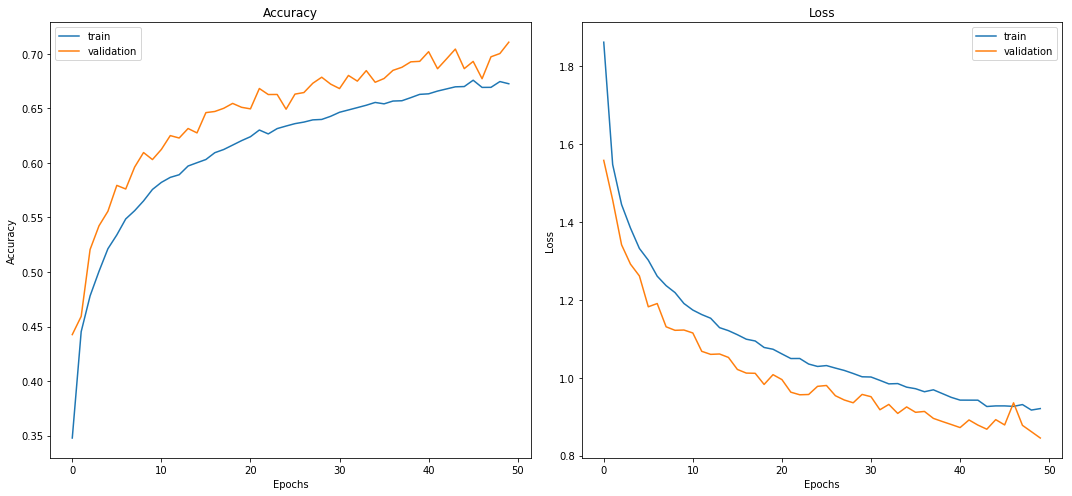

In [11]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(hist.history['acc'], label='train')
plt.plot(hist.history['val_acc'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [13]:
preds = np.argmax(model.predict(X_test), axis = 1)
y_orig = np.argmax(y_test, axis = 1)
cm = confusion_matrix(preds, y_orig)

Normalized confusion matrix


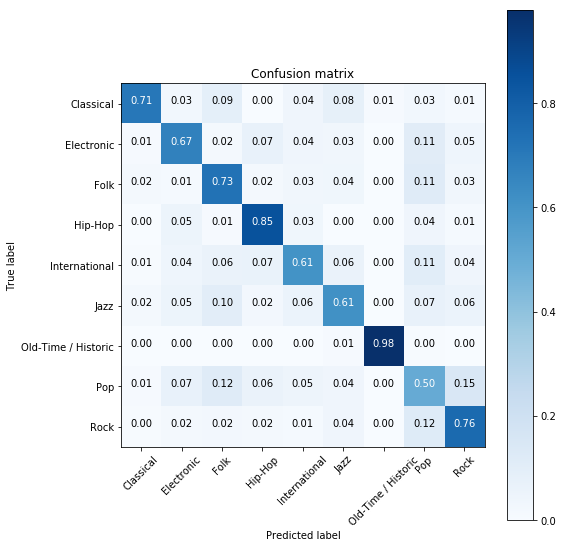

In [18]:
keys = OrderedDict(sorted(genres.items(), key=lambda t: t[1])).keys()

plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, keys, normalize=True)